# ML BUSINESS PROJECT

In this project we will work with 1000 samples to find the distribution of profit for 3 seperate geo locations that have potential for the OilyGiant mining company to develop a new well.<br/>
In order to find the best location I will  Build a model for predicting the volume of reserves in the new wells and Calculate the volume of reserves sufficient for developing a new well without losses. The wells with the highest values of predictions will be chosen and double checked with the bootstrap technique. I will find average profit with a 95% confidence interval and  show all risk of losses through a percentage.

In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree

## Initialize Data

In [2]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

total_wells = 200
budget = 100000000 
revenue_per_barrel = 4500

## EDA

In [3]:
display(geo_data_0.head())
display(geo_data_0.info())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

In [4]:
display(geo_data_0.isnull().sum())
display(geo_data_0.duplicated().sum())

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

0

In [5]:
geo_data_0['id'].duplicated().sum()

10

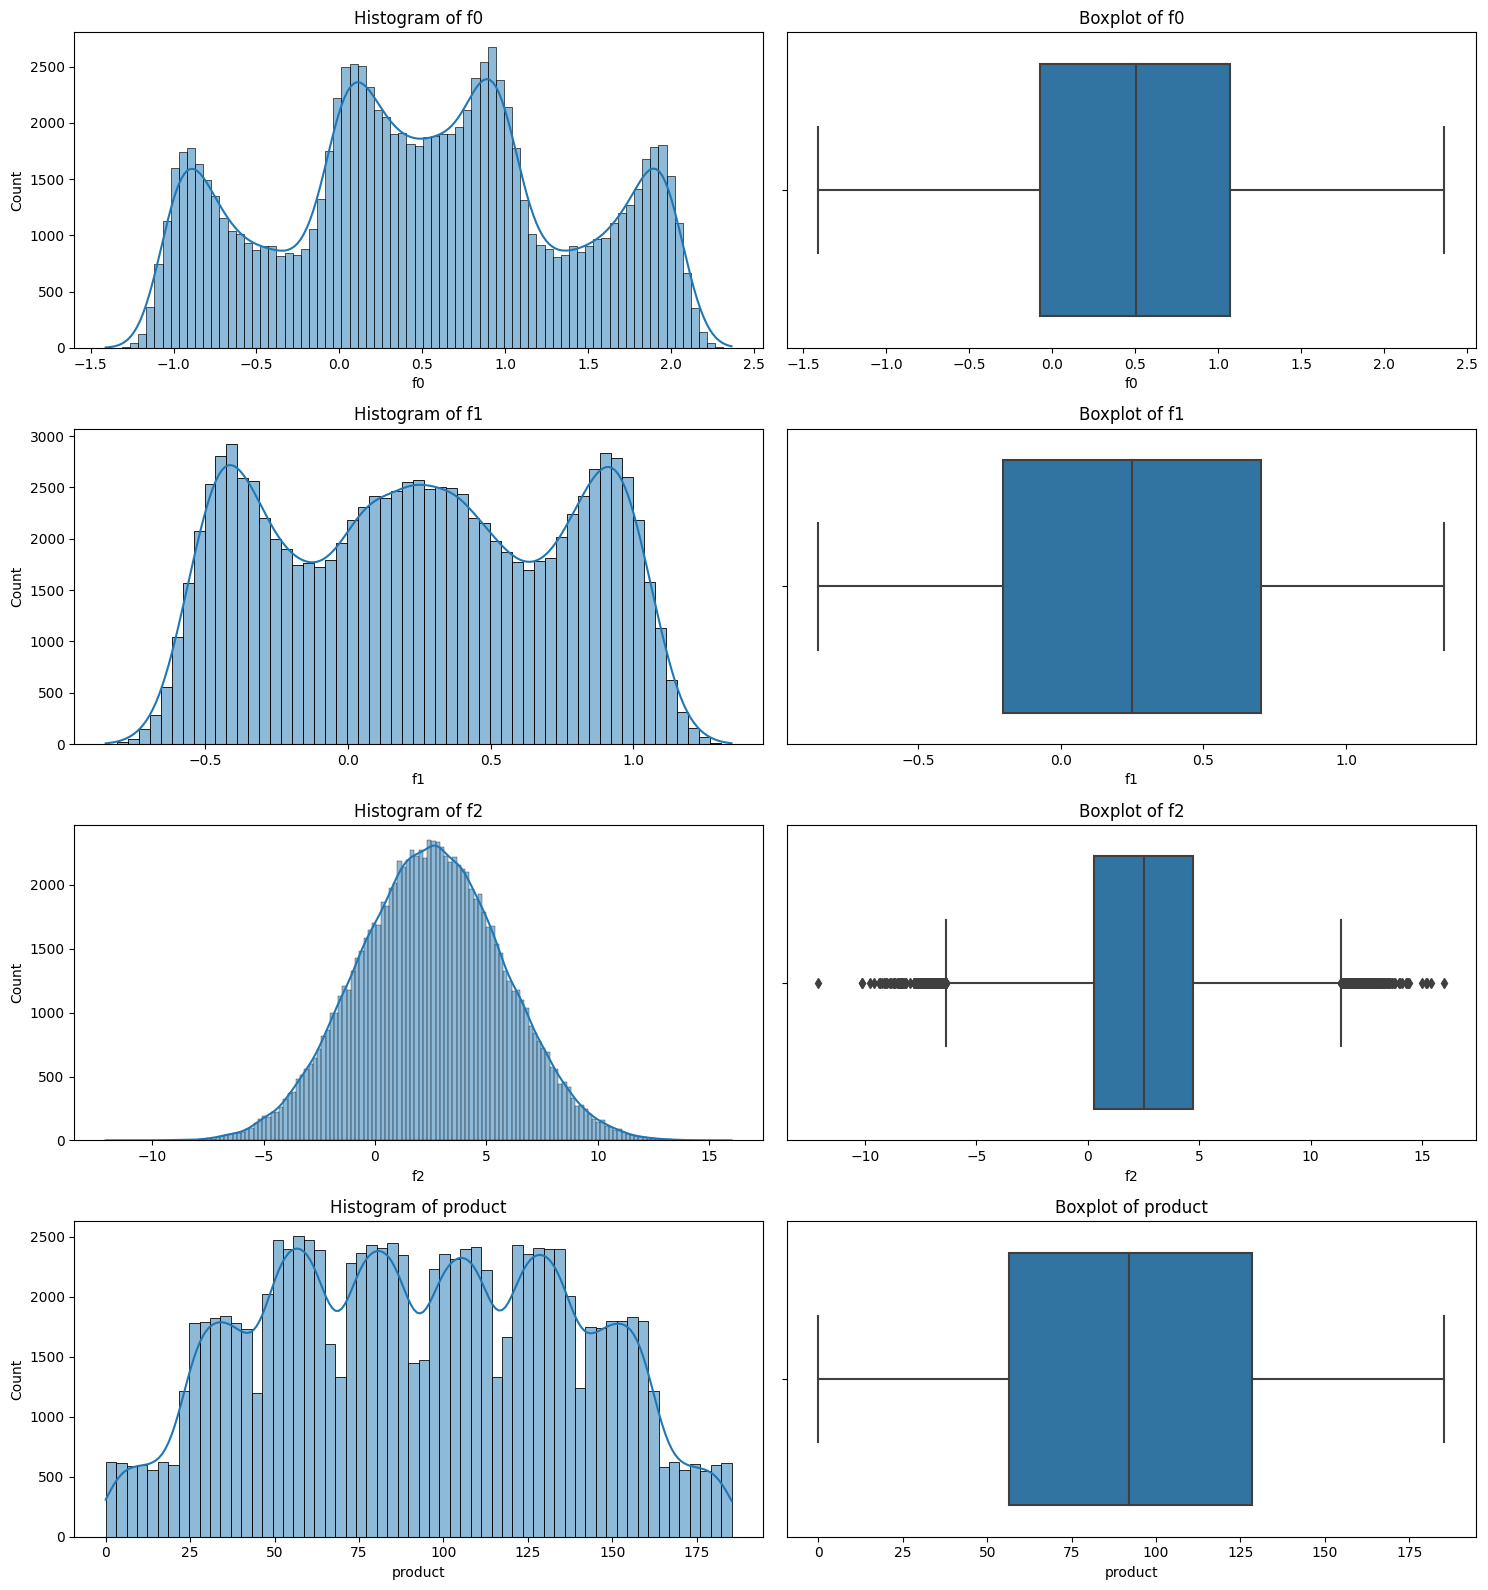

In [6]:
def plot_distributions(data, feature_names, target_name):
    num_plots = len(feature_names) + 1
    plt.figure(figsize=(15, 4 * num_plots))

    # Plot each feature
    for i, feature in enumerate(feature_names):
        plt.subplot(num_plots, 2, 2 * i + 1)
        sns.histplot(data[feature], kde=True)
        plt.title(f'Histogram of {feature}')

        plt.subplot(num_plots, 2, 2 * i + 2)
        sns.boxplot(x=data[feature])
        plt.title(f'Boxplot of {feature}')

    # Plot target
    plt.subplot(num_plots, 2, 2 * len(feature_names) + 1)
    sns.histplot(data[target_name], kde=True)
    plt.title(f'Histogram of {target_name}')

    plt.subplot(num_plots, 2, 2 * len(feature_names) + 2)
    sns.boxplot(x=data[target_name])
    plt.title(f'Boxplot of {target_name}')

    plt.tight_layout()
    plt.show()

# Example usage
feature_names = ['f0', 'f1', 'f2']  # Replace with your actual feature names
target_name = 'product'  # Replace with your actual target name

plot_distributions(geo_data_0, feature_names, target_name)

features and targets<br/><br/> 
f0 & f1 are multimodal:
The presence of multiple peaks indicates that these features might have subgroups or clusters within the data. This could suggest different underlying processes or influences affecting these features.<br/>
techniques like clustering could be used to identify distinct groups. Additionally, separate models for each subgroup might improve predictions.
 <br/>
f2 is normally distributed:
This feature is symmetrically distributed around a central value, with most data falling close to the mean.<br/>
Normally distributed features generally don't require transformation and can be directly used in many modeling techniques that assume normality.

In [7]:
display(geo_data_1.head())
display(geo_data_1.info())

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

In [8]:
display(geo_data_1.isnull().sum())
display(geo_data_1.duplicated().sum())

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

0

In [9]:
geo_data_1['id'].duplicated().sum()

4

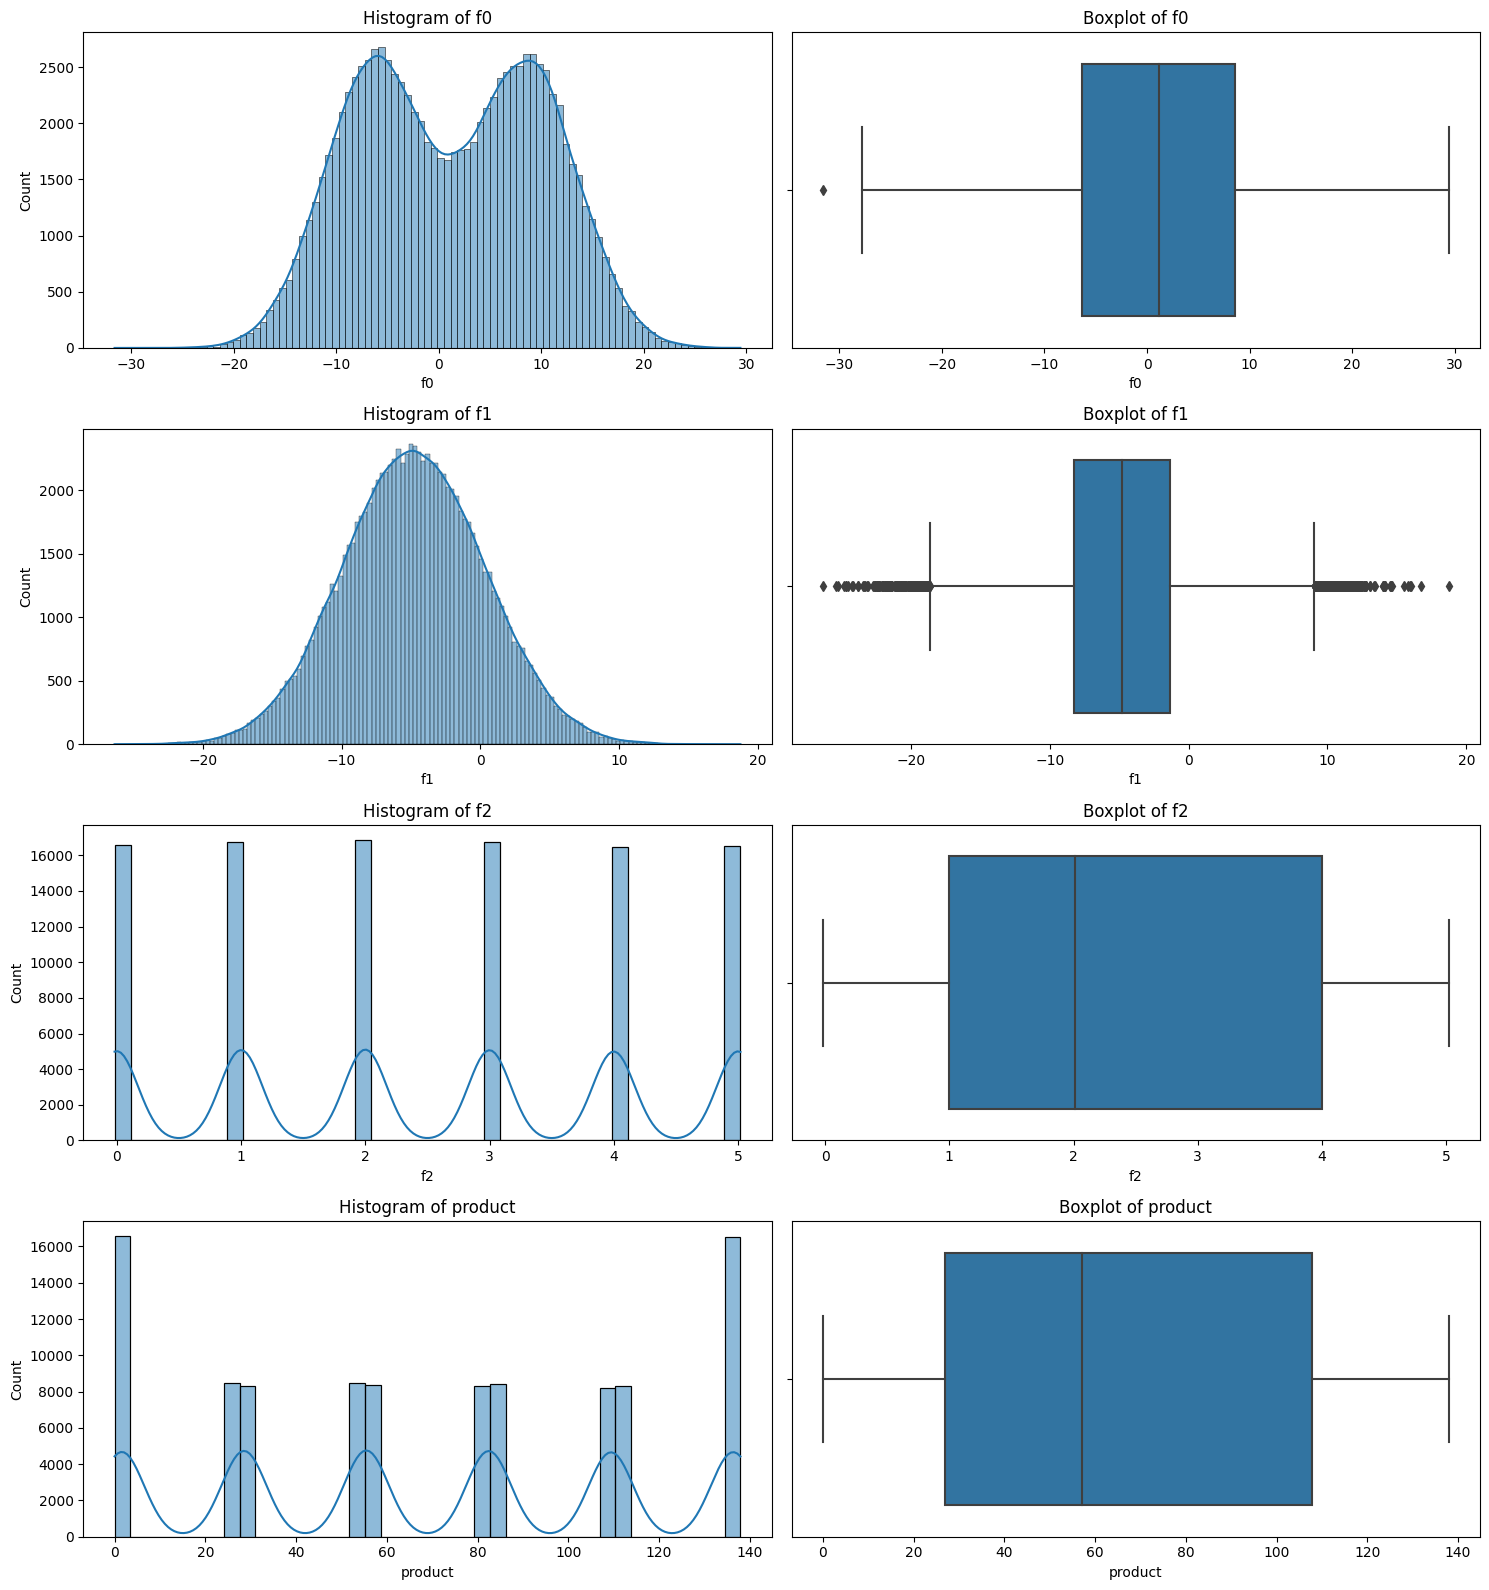

In [10]:
def plot_distributions(data, feature_names, target_name):
    num_plots = len(feature_names) + 1
    plt.figure(figsize=(15, 4 * num_plots))

    # Plot each feature
    for i, feature in enumerate(feature_names):
        plt.subplot(num_plots, 2, 2 * i + 1)
        sns.histplot(data[feature], kde=True)
        plt.title(f'Histogram of {feature}')

        plt.subplot(num_plots, 2, 2 * i + 2)
        sns.boxplot(x=data[feature])
        plt.title(f'Boxplot of {feature}')

    # Plot target
    plt.subplot(num_plots, 2, 2 * len(feature_names) + 1)
    sns.histplot(data[target_name], kde=True)
    plt.title(f'Histogram of {target_name}')

    plt.subplot(num_plots, 2, 2 * len(feature_names) + 2)
    sns.boxplot(x=data[target_name])
    plt.title(f'Boxplot of {target_name}')

    plt.tight_layout()
    plt.show()

# Example usage
feature_names = ['f0', 'f1', 'f2']  # Replace with your actual feature names
target_name = 'product'  # Replace with your actual target name

plot_distributions(geo_data_1, feature_names, target_name)

features and targets<br/><br/>
f0: Shows a multimodal pattern, indicating possible different subgroups or categorical nature.<br/>
f1: Looks normally distributed but has significant outliers that might need handling.<br/>
f2: Shows clear multimodal patterns, indicating different subgroups or categorical nature.

In [11]:
display(geo_data_2.head())
display(geo_data_2.info())

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

In [12]:
display(geo_data_2.isnull().sum())
display(geo_data_2.duplicated().sum())

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

0

In [13]:
geo_data_2['id'].duplicated().sum()

4

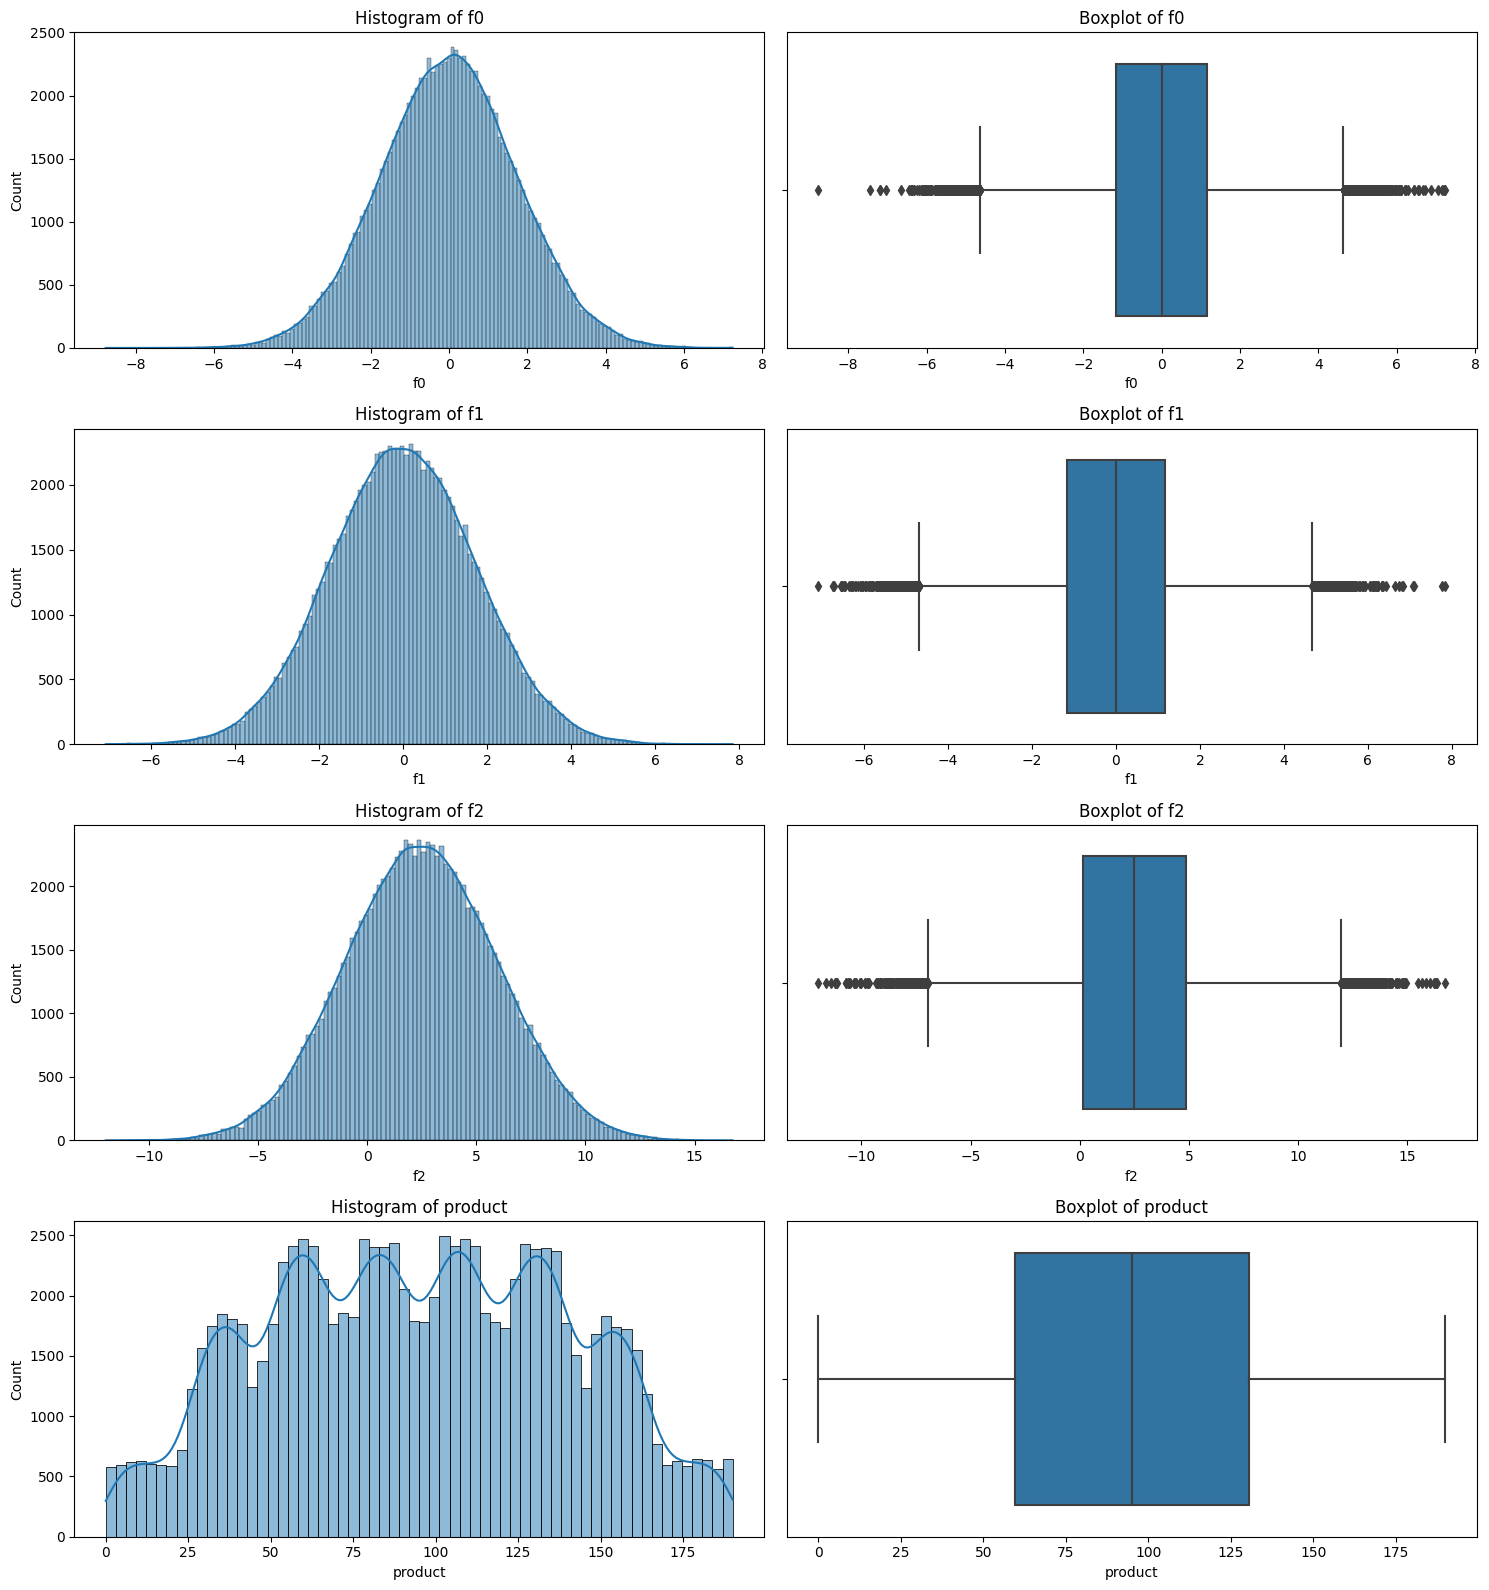

In [14]:
def plot_distributions(data, feature_names, target_name):
    num_plots = len(feature_names) + 1
    plt.figure(figsize=(15, 4 * num_plots))

    # Plot each feature
    for i, feature in enumerate(feature_names):
        plt.subplot(num_plots, 2, 2 * i + 1)
        sns.histplot(data[feature], kde=True)
        plt.title(f'Histogram of {feature}')

        plt.subplot(num_plots, 2, 2 * i + 2)
        sns.boxplot(x=data[feature])
        plt.title(f'Boxplot of {feature}')

    # Plot target
    plt.subplot(num_plots, 2, 2 * len(feature_names) + 1)
    sns.histplot(data[target_name], kde=True)
    plt.title(f'Histogram of {target_name}')

    plt.subplot(num_plots, 2, 2 * len(feature_names) + 2)
    sns.boxplot(x=data[target_name])
    plt.title(f'Boxplot of {target_name}')

    plt.tight_layout()
    plt.show()

# Example usage
feature_names = ['f0', 'f1', 'f2']  # Replace with your actual feature names
target_name = 'product'  # Replace with your actual target name

plot_distributions(geo_data_2, feature_names, target_name)

features and targets<br/><br/>
f0: Looks normally distributed but has significant outliers that might need handling.<br/>
f1: Looks normally distributed but has significant outliers that might need handling.<br/>
f2: Looks normally distributed but has significant outliers that might need handling.<br/>

# geo_data_0

## Split The data


In [15]:
X = geo_data_0[['f0', 'f1', 'f2']]
y = geo_data_0['product']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)

## Train Model & Make Predictions

In [16]:
model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_valid)

## Save Predictions and Correct Answers

In [17]:
results = pd.DataFrame({'Actual': y_valid, 'Predicted': predictions})
results

,Actual,Predicted
75721,122.073350,101.901017
80184,48.738540,78.217774
19864,131.338088,115.266901
76699,88.327757,105.618618
92991,36.959266,97.980185
...,...,...
21271,148.821520,105.076959
34014,123.454003,74.768176
81355,91.945213,82.544397
65720,149.295563,81.826689


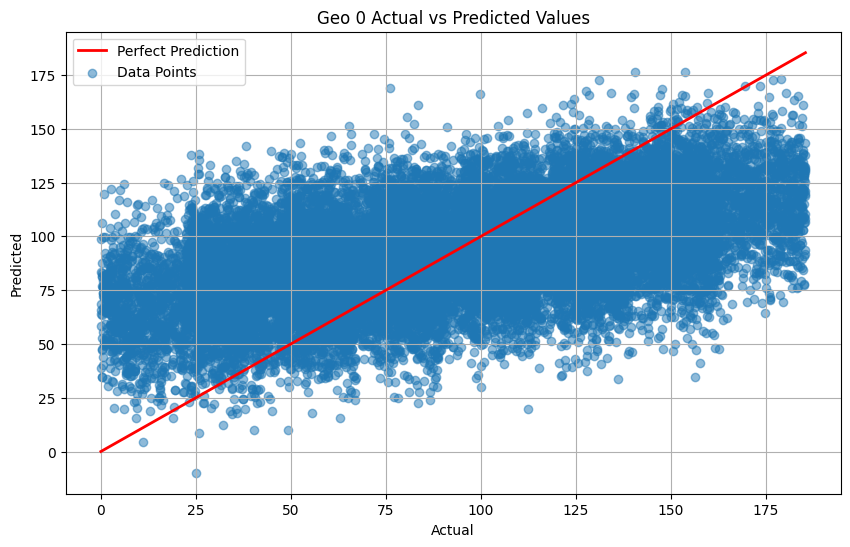

In [18]:
plt.figure(figsize=(10, 6))


plt.scatter(results['Actual'], results['Predicted'], alpha=0.5, label='Data Points')


plt.plot([results['Actual'].min(), results['Actual'].max()], 
         [results['Actual'].min(), results['Actual'].max()], 
         color='red', linewidth=2, label='Perfect Prediction')


plt.title('Geo 0 Actual vs Predicted Values')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.grid(True)

plt.show()

There is no consistnancy between actual and predicted volumes.

## Print average volume and RMSE for each site

In [19]:
rmse = np.sqrt(mean_squared_error(y_valid, predictions))
average_volume = predictions.mean()

print(f'Average Predicted Volume: {average_volume}')
print(f'RMSE: {rmse}')

Average Predicted Volume: 92.3987999065777
RMSE: 37.756600350261685


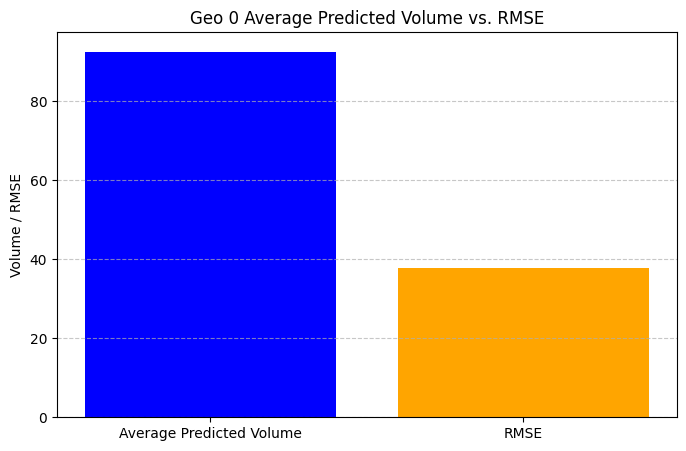

In [20]:
import matplotlib.pyplot as plt


values = [average_volume, rmse]
labels = ['Average Predicted Volume', 'RMSE']


plt.figure(figsize=(8, 5))
plt.bar(labels, values, color=['blue', 'orange'])


plt.title('Geo 0 Average Predicted Volume vs. RMSE')
plt.ylabel('Volume / RMSE')
plt.ylim(0, max(values) + 5) 
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

Average Predicted Volume: The mean of the predicted reserve volumes for the validation set.This model expects there to be 92.39 on average

RMSE (Root Mean Squared Error): This metric is key for assessing the model's performance. It represents the average difference between the predicted and actual reserve volumes. A lower RMSE indicates better accuracy. this model's RSME is 37 and that is high.


# geo_data_1

In [21]:
X1 = geo_data_1[['f0', 'f1', 'f2']]
y1 = geo_data_1['product']

X1_train, X1_valid, y1_train, y1_valid = train_test_split(X1, y1, test_size=0.25, random_state=42)

In [22]:
model1 = LinearRegression()
model1.fit(X1_train, y1_train)
predictions1 = model1.predict(X1_valid)

In [23]:
results1 = pd.DataFrame({'Actual': y1_valid, 'Predicted': predictions})
results1

,Actual,Predicted
75721,0.000000,101.901017
80184,53.906522,78.217774
19864,134.766305,115.266901
76699,107.813044,105.618618
92991,0.000000,97.980185
...,...,...
21271,107.813044,105.076959
34014,53.906522,74.768176
81355,26.953261,82.544397
65720,110.992147,81.826689


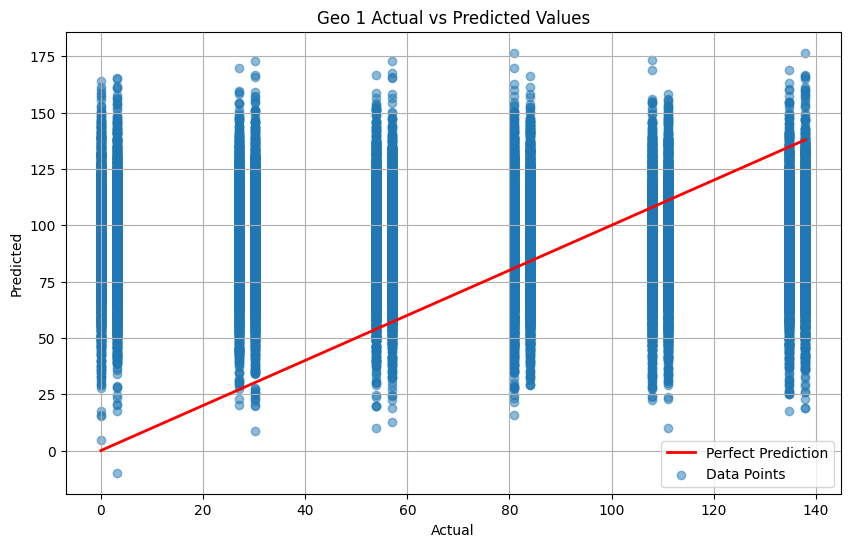

In [24]:
plt.figure(figsize=(10, 6))


plt.scatter(results1['Actual'], results1['Predicted'], alpha=0.5, label='Data Points')


plt.plot([results1['Actual'].min(), results1['Actual'].max()], 
         [results1['Actual'].min(), results1['Actual'].max()], 
         color='red', linewidth=2, label='Perfect Prediction')


plt.title('Geo 1 Actual vs Predicted Values')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.grid(True)

plt.show()

In [25]:
rmse1 = np.sqrt(mean_squared_error(y1_valid, predictions1))
average_volume1 = predictions1.mean()

print(f'Average Predicted Volume: {average_volume1}')
print(f'RMSE: {rmse1}')

Average Predicted Volume: 68.71287803913762
RMSE: 0.890280100102884


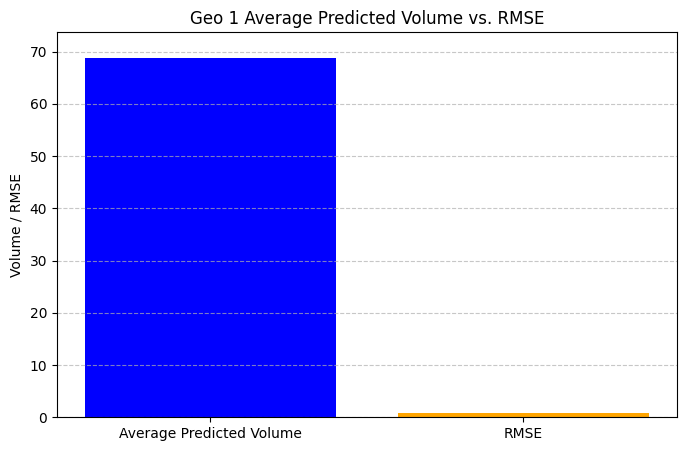

In [26]:
import matplotlib.pyplot as plt


values = [average_volume1, rmse1]
labels = ['Average Predicted Volume', 'RMSE']


plt.figure(figsize=(8, 5))
plt.bar(labels, values, color=['blue', 'orange'])


plt.title('Geo 1 Average Predicted Volume vs. RMSE')
plt.ylabel('Volume / RMSE')
plt.ylim(0, max(values) + 5)  
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

average predicted volume is 68.71<br/>
RSME is 0.89 much lower than geo_data_0

# geo_data_2

In [27]:
X2 = geo_data_2[['f0', 'f1', 'f2']]
y2 = geo_data_2['product']

X2_train, X2_valid, y2_train, y2_valid = train_test_split(X2, y2, test_size=0.25, random_state=42)

In [28]:
model2 = LinearRegression()
model2.fit(X2_train, y2_train)
predictions2 = model2.predict(X2_valid)

In [29]:
results2 = pd.DataFrame({'Actual': y2_valid, 'Predicted': predictions2})
results2

,Actual,Predicted
75721,117.441301,98.301916
80184,47.841249,101.592461
19864,45.883483,52.449099
76699,139.014608,109.922127
92991,84.004276,72.411847
...,...,...
21271,40.797226,102.764169
34014,87.144239,93.431823
81355,52.039812,64.098390
65720,136.961454,83.764135


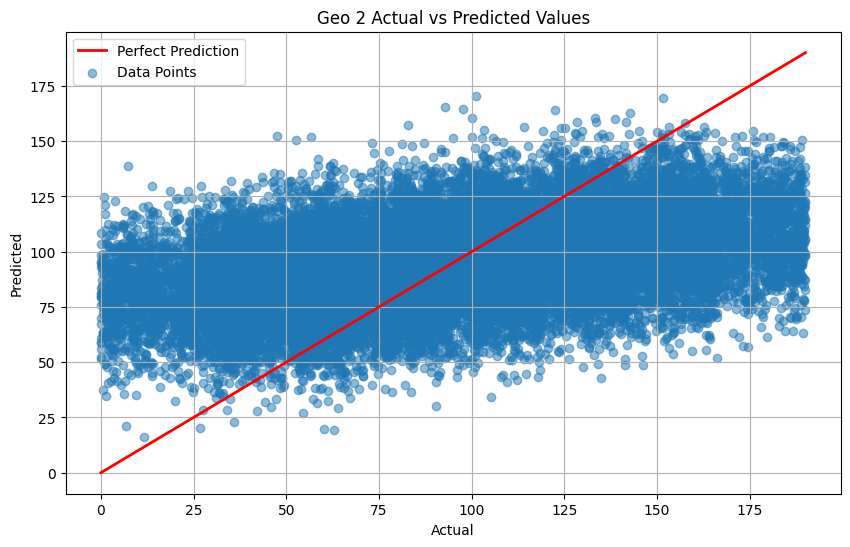

In [30]:
plt.figure(figsize=(10, 6))


plt.scatter(results2['Actual'], results2['Predicted'], alpha=0.5, label='Data Points')


plt.plot([results2['Actual'].min(), results2['Actual'].max()], 
         [results2['Actual'].min(), results2['Actual'].max()], 
         color='red', linewidth=2, label='Perfect Prediction')


plt.title('Geo 2 Actual vs Predicted Values')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.grid(True)

plt.show()

In [31]:
rmse2 = np.sqrt(mean_squared_error(y2_valid, predictions2))
average_volume2 = predictions2.mean()

print(f'Average Predicted Volume: {average_volume2}')
print(f'RMSE: {rmse2}')

Average Predicted Volume: 94.77102387765939
RMSE: 40.14587231134218


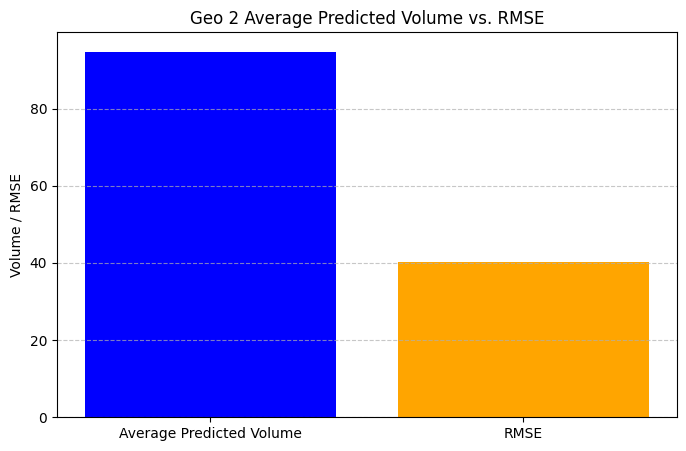

In [32]:
import matplotlib.pyplot as plt


values = [average_volume2, rmse2]
labels = ['Average Predicted Volume', 'RMSE']


plt.figure(figsize=(8, 5))
plt.bar(labels, values, color=['blue', 'orange'])


plt.title('Geo 2 Average Predicted Volume vs. RMSE')
plt.ylabel('Volume / RMSE')
plt.ylim(0, max(values) + 5) 
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

Average Predicted Volume is 94.77<br/>
RMSE is 40.14 which is the highest of the 3 locations

# Best Geo Data

based on the RMSE values, geo_data_1 has the best (lowest) RMSE, indicating it has the most accurate predictions among the regions.<br/> This region is likely the most promising for development based on predictive accuracy.

In [33]:
print(f'Average Volume: {average_volume}')
print(f'Average Volume1: {average_volume1}')
print(f'Average Volume2: {average_volume2}')

print(f'RMSE: {rmse}')
print(f'RMSE1: {rmse1}')
print(f'RMSE2: {rmse2}') 


Average Volume: 92.3987999065777
Average Volume1: 68.71287803913762
Average Volume2: 94.77102387765939
RMSE: 37.756600350261685
RMSE1: 0.890280100102884
RMSE2: 40.14587231134218


In [34]:
cost_per_well = budget / total_wells
volume_needed = cost_per_well / revenue_per_barrel

print(f"Volume Needed for Profitability: {volume_needed}")

Volume Needed for Profitability: 111.11111111111111


In [35]:
print(f"geo_data_0 Average Volume: {average_volume}")
print(f"geo_data_1 Average Volume: {average_volume1}")
print(f"geo_data_2 Average Volume: {average_volume2}")

geo_data_0 Average Volume: 92.3987999065777
geo_data_1 Average Volume: 68.71287803913762
geo_data_2 Average Volume: 94.77102387765939


## break-even vs actual average volume

In [36]:
break_even_volume = budget / revenue_per_barrel


actual_avg_volume_0 = np.mean(y_valid.values)
actual_avg_volume_1 = np.mean(y1_valid.values)
actual_avg_volume_2 = np.mean(y2_valid.values)


print(f"Region 0: Break-even Volume: {break_even_volume}, Actual Average Volume: {actual_avg_volume_0}")
print(f"Region 1: Break-even Volume: {break_even_volume}, Actual Average Volume: {actual_avg_volume_1}")
print(f"Region 2: Break-even Volume: {break_even_volume}, Actual Average Volume: {actual_avg_volume_2}")

Region 0: Break-even Volume: 22222.222222222223, Actual Average Volume: 92.32595637084387
Region 1: Break-even Volume: 22222.222222222223, Actual Average Volume: 68.72538074722745
Region 2: Break-even Volume: 22222.222222222223, Actual Average Volume: 95.15099907171961


omparison with Predicted Volumes:<br/>
None of the regions (geo_data_0, geo_data_1, geo_data_2) have average predicted volumes less than the needed 111.11 thousand barrels per well.<br/><br/>


Since geo_data_1 has the best RSME score we will explore an alternative.<br/>
Optimize Operations:
Reduce Costs: Investigate possible ways to reduce costs per well, such as improving drilling efficiency or negotiating better rates with suppliers.
Enhance Revenue: Explore options for increasing the selling price per barrel, such as refining processes or upgrading the product grade.

Advanced Modeling:
Feature Engineering: Create new features that might improve predictions by incorporating domain knowledge or using feature transformation techniques.
Model Complexity: Experiment with more complex models or ensemble methods to see if they offer better prediction accuracy without overfitting.

Sensitivity Analysis:
Conduct a sensitivity analysis to understand the impact of varying key financial parameters like oil price or production costs on profitability.

Risk Assessment:
Evaluate the risk associated with this region using advanced techniques, considering the best and worst-case scenarios for production and pricing.

Long-Term Strategy:
Consider longer-term contracts or investments that might affect both costs and revenues positively.

## Calculating Profits

In [37]:
def calculate_profit(predictions, actual, budget, revenue_per_barrel, top_n=200):
 
    indices = np.argsort(predictions)[-top_n:] 

    
    selected_reserves = actual[indices].sum()

   
    revenue = selected_reserves * revenue_per_barrel
    profit = revenue - budget

    return profit, selected_reserves


profit, reserves = calculate_profit(predictions, y_valid.values, budget, revenue_per_barrel)
print(f"Profit: ${profit}")
print(f"Total Reserves: {reserves} thousand barrels")

Profit: $33591411.14462179
Total Reserves: 29686.9802543604 thousand barrels


We select the best 200 wells by predictions, but then we need to use target values to actually calculate profit because predictions may not be accurate. 


Recommendations
Region 0 shows the highest profit potential, despite earlier RMSE considerations.
Consider the risk and accuracy of predictions when making a final decision, but Region 0 seems to offer the best financial returns.

In [38]:
def bootstrap_profit(predictions, actual, budget, revenue_per_barrel, top_n=200, n_samples=1000):
    profits = []
    
    
    state = np.random.RandomState(315)
    for _ in range(n_samples):
        indices = state.choice(len(predictions), 500, replace=True)
        selected_predictions = predictions[indices]
        selected_actual = actual[indices]
        
        top_indices = np.argsort(selected_predictions)[-top_n:]
        selected_reserves = selected_actual[top_indices].sum()
        
        revenue = selected_reserves * revenue_per_barrel
        profit = revenue - budget
        profits.append(profit)
    
    return profits

profit_0, reserves_0 = calculate_profit(predictions, y_valid.values, budget, revenue_per_barrel)
profit_1, reserves_1 = calculate_profit(predictions1, y1_valid.values, budget, revenue_per_barrel)
profit_2, reserves_2 = calculate_profit(predictions2, y2_valid.values, budget, revenue_per_barrel)

print(f"Region 0 Profit: ${profit_0}, Total Reserves: {reserves_0} thousand barrels")
print(f"Region 1 Profit: ${profit_1}, Total Reserves: {reserves_1} thousand barrels")
print(f"Region 2 Profit: ${profit_2}, Total Reserves: {reserves_2} thousand barrels")

Region 0 Profit: $33591411.14462179, Total Reserves: 29686.9802543604 thousand barrels
Region 1 Profit: $24150866.966815114, Total Reserves: 27589.081548181137 thousand barrels
Region 2 Profit: $25985717.593741104, Total Reserves: 27996.826131942467 thousand barrels


## Bootstrap profit

## Average Profit, Confidence Interval & Risk

In [39]:
profits_region_0 = bootstrap_profit(predictions, y_valid.values, budget, revenue_per_barrel)
profits_region_1 = bootstrap_profit(predictions1, y1_valid.values, budget, revenue_per_barrel)
profits_region_2 = bootstrap_profit(predictions2, y2_valid.values, budget, revenue_per_barrel)


average_profit_0 = np.mean(profits_region_0)
average_profit_1 = np.mean(profits_region_1)
average_profit_2 = np.mean(profits_region_2)


conf_interval_0 = np.percentile(profits_region_0, [2.5, 97.5])
conf_interval_1 = np.percentile(profits_region_1, [2.5, 97.5])
conf_interval_2 = np.percentile(profits_region_2, [2.5, 97.5])


risk_0 = np.mean(np.array(profits_region_0) < 0)
risk_1 = np.mean(np.array(profits_region_1) < 0)
risk_2 = np.mean(np.array(profits_region_2) < 0)

print(f"Region 0: Average Profit: ${average_profit_0}, 95% CI: {conf_interval_0}, Risk: {risk_0*100}%")
print(f"Region 1: Average Profit: ${average_profit_1}, 95% CI: {conf_interval_1}, Risk: {risk_1*100}%")
print(f"Region 2: Average Profit: ${average_profit_2}, 95% CI: {conf_interval_2}, Risk: {risk_2*100}%")

Region 0: Average Profit: $4001465.90406427, 95% CI: [-1122953.0168321   8876432.94223494], Risk: 7.199999999999999%
Region 1: Average Profit: $4469014.193144879, 95% CI: [ 588606.0722923  8645972.45850532], Risk: 0.5%
Region 2: Average Profit: $3682387.5858448297, 95% CI: [-1776842.75457505  9044286.03069418], Risk: 9.0%


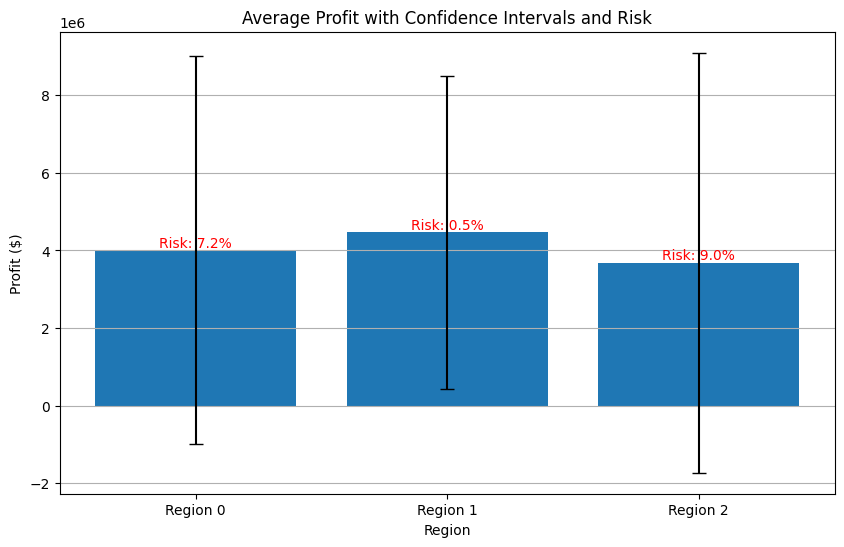

In [40]:
regions = ['Region 0', 'Region 1', 'Region 2']
average_profits = [average_profit_0, average_profit_1, average_profit_2]
conf_intervals = [conf_interval_0, conf_interval_1, conf_interval_2]
risks = [risk_0, risk_1, risk_2]


plt.figure(figsize=(10, 6))


plt.bar(regions, average_profits, yerr=[(conf[1] - conf[0]) / 2 for conf in conf_intervals], capsize=5, label='Average Profit')


for i, risk in enumerate(risks):
    plt.text(i, average_profits[i], f'Risk: {risk*100:.1f}%', ha='center', va='bottom', fontsize=10, color='red')


plt.title('Average Profit with Confidence Intervals and Risk')
plt.xlabel('Region')
plt.ylabel('Profit ($)')
plt.grid(axis='y')

plt.show()

Profitability: Region 1 shows the highest average profit and a strong confidence interval.<br/>
Risk: All regions have a risk of loss, but Region 1 has the most safety at 0.5% risk.<br/>
Recommendation: Based on profitability and low risk, Region 1 is the best choice for development.

## Decision

Selected Region: Region 1

Justification<br/>
Profitability:
Region 1 shows the highest profit potential at approximately 44 million.

Reserve Volume:
The total reserves are substantial, indicating a reliable supply that aligns with economic goals.

Prediction Accuracy:
Region 1 has a better RMSE of 0.89. Also, the higher profit in Region 1 suggests that model predictions align sufficiently with actual reserves to justify the investment.

Risk and Strategy:
Assess any associated risks, such as market volatility or extraction costs, and outline mitigation strategies.

Overall Value:
Combining profitability with acceptable accuracy makes Region 1 the best choice for development.

Actionable Steps
Proceed with development plans in Region 1.
Continuously monitor market conditions and model performance.
Strategize on cost management to further enhance profitability.